In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-drone-dataset/class_dict_seg.csv
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/173.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/491.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/043.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/248.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/038.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/480.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/236.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/083.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/513.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_da

# Imports and Installs

In [2]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [3]:
import re
import gc
import os
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Pytorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
import segmentation_models_pytorch as smp
import torch.utils.data as data
from tqdm.notebook import tqdm



### Check for GPU

In [4]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Raw Data Directories

In [5]:
og_img_dir = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
label_img_dir = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'
rgb_mask_dir = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

### Resized Directories

In [6]:
resized_og_img_dir = "/kaggle/working/resized_original_images"
resized_label_img_dir = "/kaggle/working/resized_label_images_semantic"
resized_rgb_masks_dir = "/kaggle/working/resized_rgb_color_image_masks"

In [7]:
img_height, img_width = 704, 1280
batch_size = 3

# Preprocessing

In [8]:
# Initialize lists to store image dimensions
widths = []
heights = []

# Loop through the images and get their sizes
for filename in sorted(os.listdir(og_img_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(og_img_dir, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Convert lists to numpy arrays for easier statistical calculations
widths = np.array(widths)
heights = np.array(heights)

# Calculate statistics
median_width = np.median(widths)
median_height = np.median(heights)
min_width = np.min(widths)
min_height = np.min(heights)
max_width = np.max(widths)
max_height = np.max(heights)

# Display the results
print(f"Median Width: {float(median_width):.2f}")
print(f"Median Height: {float(median_height):.2f}")
print(f"Minimum Width: {float(min_width):.2f}")
print(f"Minimum Height: {float(min_height):.2f}")
print(f"Maximum Width: {float(max_width):.2f}")
print(f"Maximum Height: {float(max_height):.2f}")

Median Width: 6000.00
Median Height: 4000.00
Minimum Width: 6000.00
Minimum Height: 4000.00
Maximum Width: 6000.00
Maximum Height: 4000.00


## Resize Images

The RTMP stream that I will be making real-time inferences on is in 720p, therefore the images must be resized and trained on that resolution. U-Net architecture requires both width and height dimensions be divisible by 32. Therefore, the final resolution will be 704x1280.

In [9]:
supported_extensions = ['.jpg', '.png']

# Function to resize images. U-Net must be divisible by 32, so dimensions are 1280 and 704.
def resize_image(image_path, target_size=(1280, 704)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    return img_resized

# Function to sort filenames numerically
def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return [int(num) for num in numbers]

# Ensure target directories exist but only populate if they are empty
def ensure_directory_empty(directory):
    """Check if a directory is empty and create it if it's empty."""
    os.makedirs(directory, exist_ok=True)
    if not os.listdir(directory):
        return True
    return False

def resize_images_in_directory(source_dir, target_dir):
    """Resize images in a directory withhttps://www.youtube.com/ numerical sorting and save as PNG in target directory."""
    if ensure_directory_empty(target_dir):
        filenames = [f for f in os.listdir(source_dir) if any(f.lower().endswith(ext) for ext in supported_extensions)]
        filenames = sorted(filenames, key=numerical_sort)

        for filename in filenames:
            image_path = os.path.join(source_dir, filename)
            img_resized = resize_image(image_path, target_size=(1280, 704))
            # Convert the filename to have a .png extension
            png_filename = os.path.splitext(filename)[0] + '.png'
            # Save the resized image using cv2.imwrite
            cv2.imwrite(os.path.join(target_dir, png_filename), img_resized)
    else:
        print(f"Skipping directory '{target_dir}' as it is not empty.")

# Resize images in the original, label, and mask directories
resize_images_in_directory(og_img_dir, resized_og_img_dir)
print(f'Original Images Resized...')
resize_images_in_directory(label_img_dir, resized_label_img_dir)
print(f'Label Images Resized...')

Original Images Resized...
Label Images Resized...


In [10]:
img = Image.open('/kaggle/working/resized_label_images_semantic/455.png')
img_array = np.array(img)
np.unique(img_array)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=uint8)

In [11]:
img = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/455.png')
img_array = np.array(img)
np.unique(img_array)

array([ 0,  1,  4,  5,  6,  8,  9, 10, 12, 13, 14, 15, 19, 21, 22],
      dtype=uint8)

## Data Loader

In [17]:
class DroneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, mean, std, transform=None, patch=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

        # Filter file_list to only include valid files that exist in both directories
        self.valid_files = self._get_valid_files()

    def _get_valid_files(self):
        valid_files = []
        for filename in self.file_list:
            img_path = os.path.join(self.image_dir, filename)
            mask_path = os.path.join(self.mask_dir, filename)
            if os.path.exists(img_path) and os.path.exists(mask_path):
                valid_files.append(filename)
        return valid_files

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the valid filename from the filtered list
        filename = self.valid_files[idx]
        img_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        # Load the image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Assuming masks are grayscale

        if self.transform:
            image = self.transform(image)

        # Convert to tensor if not done in transform
        image = transforms.ToTensor()(image) if not isinstance(image, torch.Tensor) else image
        mask = torch.tensor(np.array(mask), dtype=torch.float32).squeeze(1)

        return image, mask

## Train-Val Split

In [20]:
img = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png')

img_array = np.array(img)
np.unique(img_array)

array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)

In [21]:
from torchvision import transforms

# Paths to directories
mask_dir = "/kaggle/working/resized_label_images_semantic"
train_dir = "/kaggle/working/resized_original_images"

# List all files in the directory
image_files = sorted(os.listdir(train_dir))
mask_files = sorted(os.listdir(mask_dir))

# Ensure that the same images are in both directories
assert len(image_files) == len(mask_files), "Mismatch between image and mask files"

# Split the data
X_train, X_val = train_test_split(image_files, test_size=0.2, random_state=42)

# Define normalization parameters (mean and std need to be computed for your dataset or can use common values)
mean = [0.485, 0.456, 0.406]  # Example values for mean
std = [0.229, 0.224, 0.225]   # Example values for std

# Define transformations
t_train = transforms.Compose([
    transforms.Resize((704, 1280)),  # Resize to the desired size
    transforms.ToTensor()
])

t_val = transforms.Compose([
    transforms.Resize((704, 1280)),  # Resize to the desired size
    transforms.ToTensor()
])

# Create the datasets
train_set = DroneDataset(train_dir, mask_dir, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(train_dir, mask_dir, X_val, mean, std, t_val, patch=False)

# Define DataLoader
batch_size = 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

print(train_loader)
print(val_loader)

# Model Training

In [22]:
model = smp.Unet('timm-mobilenetv3_small_minimal_100', 
                 encoder_weights='imagenet', 
                 classes=23, 
                 activation=None, 
                 encoder_depth=5, 
                 decoder_channels=[256, 128, 64, 32, 16],
                )
model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_minimal_100-922a7843.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_minimal_100-922a7843.pth
100%|██████████| 7.88M/7.88M [00:00<00:00, 89.7MB/s]


Unet(
  (encoder): MobileNetV3Encoder(
    (model): MobileNetV3Features(
      (conv_stem): Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2dSame(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16, bias=False)
            (bn1): BatchNormAct2d(
              16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (se): Identity()
            (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNormAct2d(
              16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (

In [23]:
# # Move the model to GPU
# model = model.to('cuda')

# # Create a dummy input tensor and move it to GPU
# dummy_input = torch.randn(1, 3, 704, 1280).to('cuda')
# # Create a dummy input tensor with shape [batch_size, channels, height, width]

# # Pass the dummy input through the model
# output = model(dummy_input)

# # Print the output shape
# print(output.shape)  # Should be [1, 3, 704, 1280]

In [24]:
epochs = 10

## Performance Metrics

In [25]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [26]:
def mIoU(pred_mask, mask, smooth=1e-6, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou = []
        for cls in range(n_classes):
            intersection = ((pred_mask == cls) & (mask == cls)).sum().item()
            union = ((pred_mask == cls) | (mask == cls)).sum().item()
            iou.append((intersection + smooth) / (union + smooth))
        
        return sum(iou) / n_classes


In [27]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [28]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # Training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device).squeeze(1).long()  # Convert mask to Long type

            # Forward pass
            output = model(image)
#             print(f'Output.shape: {output.shape}')
#             print(f'Mask.shape: {mask.shape}')
            
            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
            
            running_loss += loss.item()
        
        # Validation loop
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                image_tiles, mask_tiles = data
                
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
                
                image = image_tiles.to(device)
                mask = mask_tiles.to(device).squeeze(1).long()  # Convert mask to Long type
                
                output = model(image)
                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                loss = criterion(output, mask)
                test_loss += loss.item()
        
        # Calculate mean for each batch
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))
        
        if min_loss > (test_loss / len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
            min_loss = (test_loss / len(val_loader))
            decrease += 1
            if decrease % 5 == 0:
                print('saving model...')
                torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))
        
        if (test_loss / len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = (test_loss / len(val_loader))
            print(f'Loss Not Decrease for {not_improve} time')
            if not_improve == 7:
                print('Loss not decrease for 7 times, Stop Training')
                break
        
        # IOU
        val_iou.append(val_iou_score / len(val_loader))
        train_iou.append(iou_score / len(train_loader))
        train_acc.append(accuracy / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))
        print("Epoch:{}/{}..".format(e + 1, epochs),
              "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
              "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
              "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
              "Time: {:.2f}m".format((time.time() - since) / 60))
    
    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    return history


## Run Model Training

In [29]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.402 
Epoch:1/30.. Train Loss: 2.928.. Val Loss: 2.402.. Train mIoU:0.028.. Val mIoU: 0.055.. Train Acc:0.228.. Val Acc:0.464.. Time: 0.84m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 2.402 >> 1.450 
Epoch:2/30.. Train Loss: 2.144.. Val Loss: 1.450.. Train mIoU:0.064.. Val mIoU: 0.087.. Train Acc:0.514.. Val Acc:0.663.. Time: 0.82m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.450 >> 1.190 
Epoch:3/30.. Train Loss: 1.570.. Val Loss: 1.190.. Train mIoU:0.087.. Val mIoU: 0.108.. Train Acc:0.620.. Val Acc:0.708.. Time: 0.82m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.190 >> 0.967 
saving model...
Epoch:4/30.. Train Loss: 1.318.. Val Loss: 0.967.. Train mIoU:0.105.. Val mIoU: 0.124.. Train Acc:0.658.. Val Acc:0.733.. Time: 0.83m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.967 >> 0.880 
Epoch:5/30.. Train Loss: 1.160.. Val Loss: 0.880.. Train mIoU:0.119.. Val mIoU: 0.140.. Train Acc:0.682.. Val Acc:0.755.. Time: 0.81m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/30.. Train Loss: 1.039.. Val Loss: 1.002.. Train mIoU:0.142.. Val mIoU: 0.144.. Train Acc:0.709.. Val Acc:0.712.. Time: 0.81m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.002 >> 0.776 
Epoch:7/30.. Train Loss: 0.918.. Val Loss: 0.776.. Train mIoU:0.162.. Val mIoU: 0.167.. Train Acc:0.743.. Val Acc:0.778.. Time: 0.81m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.776 >> 0.719 
Epoch:8/30.. Train Loss: 0.862.. Val Loss: 0.719.. Train mIoU:0.173.. Val mIoU: 0.181.. Train Acc:0.753.. Val Acc:0.791.. Time: 0.81m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/30.. Train Loss: 0.915.. Val Loss: 0.724.. Train mIoU:0.169.. Val mIoU: 0.184.. Train Acc:0.727.. Val Acc:0.792.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/30.. Train Loss: 0.740.. Val Loss: 0.817.. Train mIoU:0.197.. Val mIoU: 0.176.. Train Acc:0.784.. Val Acc:0.771.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.817 >> 0.657 
Epoch:11/30.. Train Loss: 0.738.. Val Loss: 0.657.. Train mIoU:0.205.. Val mIoU: 0.201.. Train Acc:0.782.. Val Acc:0.806.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.657 >> 0.656 
saving model...
Epoch:12/30.. Train Loss: 0.649.. Val Loss: 0.656.. Train mIoU:0.223.. Val mIoU: 0.205.. Train Acc:0.810.. Val Acc:0.804.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:13/30.. Train Loss: 0.655.. Val Loss: 0.664.. Train mIoU:0.220.. Val mIoU: 0.217.. Train Acc:0.808.. Val Acc:0.801.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:14/30.. Train Loss: 0.620.. Val Loss: 0.664.. Train mIoU:0.242.. Val mIoU: 0.216.. Train Acc:0.821.. Val Acc:0.811.. Time: 0.79m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.664 >> 0.558 
Epoch:15/30.. Train Loss: 0.666.. Val Loss: 0.558.. Train mIoU:0.237.. Val mIoU: 0.245.. Train Acc:0.800.. Val Acc:0.835.. Time: 0.79m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:16/30.. Train Loss: 0.541.. Val Loss: 0.589.. Train mIoU:0.268.. Val mIoU: 0.239.. Train Acc:0.842.. Val Acc:0.832.. Time: 0.79m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.589 >> 0.536 
Epoch:17/30.. Train Loss: 0.513.. Val Loss: 0.536.. Train mIoU:0.274.. Val mIoU: 0.261.. Train Acc:0.850.. Val Acc:0.847.. Time: 0.80m


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 14.52 m


## Export Model

In [30]:
os.makedirs('/kaggle/working/models/', exist_ok=True)
torch.save(model, '/kaggle/working/models/Unet-Mobilenet_V3.pt')

## Model Performance Visualizations

In [31]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

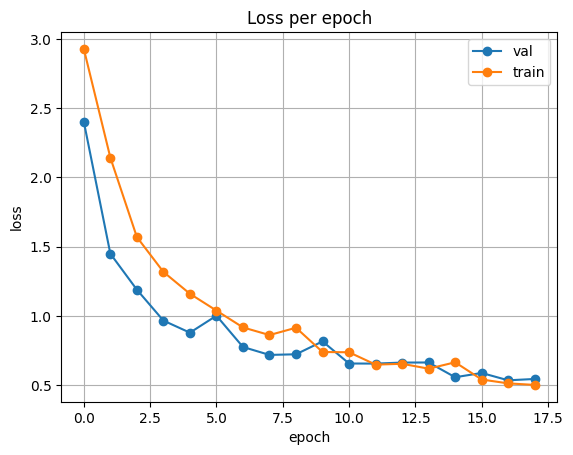

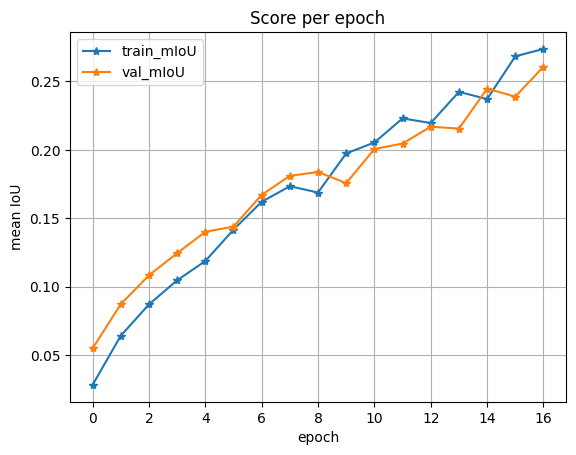

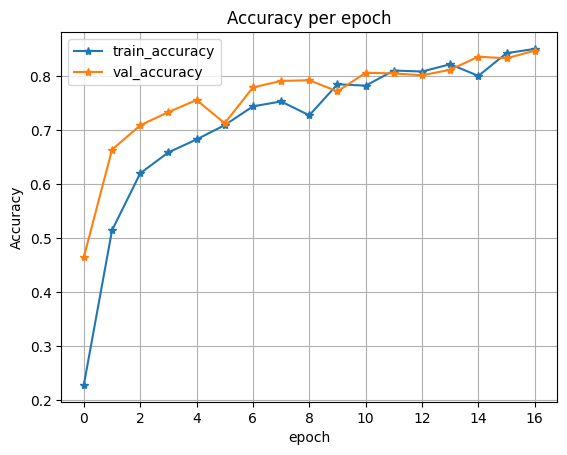

In [32]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [33]:
img = Image.open('/kaggle/working/resized_original_images/041.png').convert('RGB')

# Ensure the model is in evaluation mode
model.eval()

# Load the trained model weights (if available)
# model.load_state_dict(torch.load('path_to_saved_model.pth'))

# Define image preprocessing steps (resize, normalize, convert to tensor)
preprocess = transforms.Compose([
    transforms.Resize((704, 1280)),  # Resize to model input dimensions
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Load the input image

# Preprocess the image
input_tensor = preprocess(img)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

# Move the input tensor to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_tensor)

# The output is a tensor with shape [1, 23, 704, 1280]
# If you want to convert this to class labels (argmax across the channel dimension)
output_labels = torch.argmax(output, dim=1)

# Convert the tensor back to a numpy array (optional)
output_labels_np = output_labels.squeeze().cpu().numpy()

# You can visualize the output_labels_np or save it as an image using PIL or other libraries


In [1]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open('/kaggle/working/resized_original_images/041.png')
axs[0].imshow(img_orig)
axs[0].set_title('original image-041.jpg')
axs[0].grid(False)

img_label = Image.open("/kaggle/working/resized_label_images_semantic/041.png").convert('LA')
axs[1].imshow(img_label)
axs[1].set_title('image mask ground truth-041.jpg')
axs[1].grid(False)

img_label = Image.open("/kaggle/working/resized_label_images_semantic/041.png").convert('LA')
axs[2].imshow(output_labels_np)
axs[2].set_title('predicted rgb image-041.jpg')
axs[2].grid(False)

NameError: name 'plt' is not defined

In [ ]:
# frame = cv2.imread()

# cv2.imshow('asdf', frame)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open("/kaggle/working/resized_original_images/078.jpg")
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

img_label = Image.open("/kaggle/working/resized_encoded_labels/078.jpg").convert('LA')
axs[1].imshow(img_label)
axs[1].set_title('label image converted to grayscale-001.jpg')
axs[1].grid(False)


img_mask = Image.open("/kaggle/working/resized_rgb_color_image_masks/078.jpg")
axs[2].imshow(img_mask)
axs[2].set_title('color mask-001.png')
axs[2].grid(False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the encoded label image
def load_image(image_path):
    return Image.open(image_path).convert('L')  # Ensure the image is in grayscale mode

# Convert the image to a NumPy array
def image_to_array(image):
    return np.array(image)

# Compute and print min and max values
def compute_min_max(image_array):
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    print(f"Min value: {min_val}")
    print(f"Max value: {max_val}")

# Plot histogram of class labels
def plot_histogram(image_array):
    plt.figure(figsize=(10, 5))
    plt.hist(image_array.flatten(), bins=range(0, 25), edgecolor='black')
    plt.title('Histogram of Class Labels')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.show()

# Path to the encoded label image
image_path = "/kaggle/working/resized_encoded_labels/078.jpg"

# Load, process, and visualize
image = load_image(image_path)
image_array = image_to_array(image)
compute_min_max(image_array)
plot_histogram(image_array)


In [ ]:
# class DataLoaderSegmentation(data.Dataset):
#     def __init__(self, folder_path):
#         super(DataLoaderSegmentation, self).__init__()
#         self.img_files = glob.glob(os.path.join(folder_path,'image','*.png'))
#         self.mask_files = []
#         for img_path in img_files:
#              self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path)) 

#     def __getitem__(self, idx):
#         # Assuming the image filenames follow a pattern like '001.jpg', '002.jpg', etc.
#         img_path = os.path.join(self.img_dir, f"{idx}.jpg")
#         mask_path = os.path.join(self.mask_dir, f"{idx}.jpg")  # Use .jpg instead of .png

#         # Load the image and mask
#         image = Image.open(img_path).convert('RGB')
#         mask = Image.open(mask_path).convert('L')  # Assuming masks are grayscale

#         if self.transform:
#             image = self.transform(image)

#         return image, mask

#     def __len__(self):
#         return len(self.img_files)

In [ ]:
# from keras_segmentation.models.unet import vgg_unet

# n_classes = 23 # Aerial Semantic Segmentation Drone Dataset tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle
# model = vgg_unet(n_classes=n_classes ,  input_height=704, input_width=1280)

# model.train(
#     train_images =  "/kaggle/working/resized_original_images/",
#     train_annotations = "/kaggle/working/resized_encoded_labels/",
#     checkpoints_path = "vgg_unet",
#     epochs=epochs
# )